In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage.io import imread, imshow, concatenate_images
import cv2
import tensorflow as tf
from tensorflow import keras
import random
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy.ndimage import rotate
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten,Dense,UpSampling2D, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping

#### In our data, the placement of ships in the data has RLE encoding, so you need to write functions that will create a mask from this encoding 

In [3]:
EPOCHS = 2
BATCH_SIZE = 64  
VALIDATION_SPLIT = 0.1 
img_shape = (128,128)

## Plot function

In [4]:
def plot_train_image(img_data,path):
    fig, axes = plt.subplots(3, 3, figsize=(5, 5), constrained_layout=True)
    for i, (index, row) in enumerate(img_data.iterrows()):
        ax = axes[i // 3, i % 3]
        image_path = os.path.join(path, row['ImageId'])
        ax.imshow(imread(image_path))
        ax.axis('off')
    plt.show()
    
def plot_images_masks(images, masks):
    """Plot images and masks in a batch."""
    n = len(images)
    fig, axarr = plt.subplots(n, 2, figsize=(5, 4 * n))  
    
    for idx, (img, mask) in enumerate(zip(images, masks)):
        if n == 1:  
            ax = axarr
        else:
            ax = axarr[idx]
        
        ax[0].imshow(img)
        ax[0].set_title(f'Image {idx+1}')
        ax[0].axis('off')
        
        ax[1].imshow(mask.squeeze(), cmap='gray')  
        ax[1].set_title(f'Mask {idx+1}')
        ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_images_masks_augmentation(images, masks, num=5):
    fig, axs = plt.subplots(num, 2, figsize=(5, 5))
    for idx, ax in enumerate(axs):
        img = images[idx]
        mask = masks[idx]
        ax[0].imshow(img)
        ax[0].set_title(f'Image {idx+1}')
        ax[0].axis('off')
        ax[1].imshow(tf.squeeze(mask).numpy(), cmap='gray') 
        ax[1].set_title(f'Mask {idx+1}')
        ax[1].axis('off')
        
    plt.tight_layout()
    plt.show()

## Util functions

In [5]:
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def combine_images_masks(in_mask_list):
    img = np.zeros((768, 768), dtype=np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            img += rle_decode(mask)
    return np.expand_dims(img, -1)


def make_image_gen(masks_df, path_train,img_shape=(128, 128), batch_size = BATCH_SIZE):
    all_batches = list(masks_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(path_train, c_img_id)
            c_img = imread(rgb_path)
            c_mask = combine_images_masks(c_masks['EncodedPixels'].values)
            c_img = resize(c_img, img_shape, mode='constant', preserve_range=True)
            c_mask = resize(c_mask, img_shape, mode='constant', preserve_range=True)
            
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield (np.stack(out_rgb, 0) / 255.0), np.stack(out_mask, 0) # (np.stack(out_rgb, 0) / 127.5) - 1, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []
                
                
def gen_image_for_classification(masks_df, path_train,img_shape=(128, 128), batch_size=BATCH_SIZE):
    all_batches = list(masks_df.groupby('ImageId'))
    out_rgb = []
    out_labels = [] 
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(path_train, c_img_id)
            c_img = imread(rgb_path)
            c_mask = combine_images_masks(c_masks['EncodedPixels'].values)
            label = 1 if c_mask.any() else 0  
            
            c_img = resize(c_img, img_shape, mode='constant', preserve_range=True)
            
            out_rgb.append(c_img)
            out_labels.append(label)
            
            if len(out_rgb) >= batch_size:
                yield (np.stack(out_rgb, 0) / 255.0), np.array(out_labels)
                out_rgb, out_labels = [], []
                
        if out_rgb:
            yield (np.stack(out_rgb, 0) / 255.0), np.array(out_labels)
            out_rgb, out_labels = [], []
            
def count_len_ship(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return np.sum(img.reshape(shape).T) 


### Define our functions for augmentation

In [6]:
def custom_rotate(image, angle):
    return rotate(image, angle, reshape=False, mode='reflect')


def custom_shift(image, width_shift_range=0.1, height_shift_range=0.1):
    random_shift_layer = tf.keras.layers.experimental.preprocessing.RandomTranslation(
        height_factor=(-height_shift_range, height_shift_range),
        width_factor=(-width_shift_range, width_shift_range),
        fill_mode='reflect',
        interpolation='bilinear'
    )
    return random_shift_layer(image)


def custom_augmentation(image, mask):
    # Parameters
    rotation = 15.0
    shift = 0.1
    zoom = [0.9, 1.25]
    
    # Random rotation
    random_angles = tf.random.uniform(shape=(), minval=-rotation, maxval=rotation, dtype=tf.float32) * (3.14159 / 180)
    image = custom_rotate(image, random_angles)
    mask = custom_rotate(mask, random_angles)

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        
    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random width & height shift
    image = custom_shift(image, shift, shift)
    mask = custom_shift(mask, shift, shift)
    
    # Random zoom
    zoom_level = tf.random.uniform(shape=(), minval=zoom[0], maxval=zoom[1], dtype=tf.float32)
    image_shape = tf.shape(image)
    new_shape = tf.cast(tf.cast(image_shape[:-1], tf.float32) * zoom_level, tf.int32)
    image = tf.image.resize(image, new_shape)
    mask = tf.image.resize(mask, new_shape)
    image = tf.image.resize_with_crop_or_pad(image, image_shape[0], image_shape[1])
    mask = tf.image.resize_with_crop_or_pad(mask, image_shape[0], image_shape[1])
    return image, mask

def custom_aug_gen(in_gen):
    for in_x, in_y in in_gen:
        aug_x, aug_y = [], []
        for x, y in zip(in_x, in_y):
            augmented_x, augmented_y = custom_augmentation(x, y)
            aug_x.append(augmented_x)
            aug_y.append(augmented_y)
        
        yield tf.stack(aug_x), tf.stack(aug_y)


## Loss Functions

In [7]:
def dice(targets, inputs, smooth=1e-6):
    targets = tf.cast(targets, tf.float32)
    inputs = tf.cast(inputs, tf.float32)
    
    axis = [1, 2, 3]
    intersection = K.sum(targets * inputs, axis=axis)
    dice_f = (2 * intersection + smooth) / (K.sum(targets, axis=axis) + K.sum(inputs, axis=axis) + smooth)
    return dice_f



def dice_loss(targets, inputs, smooth=1e-6):
    dice_coeff = dice(targets, inputs, smooth)
    return 1 - dice_coeff



def weighted_binary_crossentropy(y_true, y_pred, weight=10):
    y_true = K.cast(y_true, dtype='float32')
    epsilon = 1e-15
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    loss = y_true * K.log(y_pred + epsilon) + (1. - y_true) * K.log(1. - y_pred + epsilon)
    weighted_loss = -weight * loss
    return K.mean(weighted_loss)

def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) 
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

def weighted_binary_crossentropy(targets, inputs, weight=10.0):
    bce = tf.keras.losses.binary_crossentropy(targets, inputs)
    mask = tf.where(tf.equal(targets, 1), weight, 1.0)
    weighted_bce = bce * mask
    return tf.reduce_mean(weighted_bce)

### Segmantation Model U-Net

In [8]:
def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u6 = UpSampling2D((2, 2))(c4)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

class UNet:
    def __init__(self, input_shape=(128, 128, 3)):
        self.input_shape = input_shape
        self.model = unet_model(input_shape)

    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def predict(self, image_batch):
        return self.model.predict(image_batch)
    
        
    def evaluate(self, image_batch, mask_batch):
        predictions = self.model.predict(image_batch)
        dice_score = dice(mask_batch, predictions)
        return dice_score.numpy()


### Classification Model 

In [9]:
class ShipModelClassifications:
    def __init__(self, input_shape=(128, 128, 3)):
        self.input_shape = input_shape
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(self.input_shape)
        x = Conv2D(32, (3, 3), activation='relu')(inputs)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model
    
    def evaluate(self, image_batch, target_batch, threshold=0.5):
        predictions = self.model.predict(image_batch)
        binary_predictions = (predictions > threshold).astype(int)
        correct_predictions = np.sum(binary_predictions == target_batch)
        total_images = len(target_batch)
        accuracy = correct_predictions / total_images
        return accuracy

In [10]:
data_root = '../input/airbus-ship-detection/'
path_train = os.path.join(data_root,'train_v2')
path_test = os.path.join(data_root,'test_v2')

In [11]:
masks = pd.read_csv(os.path.join('../input/airbus-ship-detection/', 'train_ship_segmentations_v2.csv'))

In [12]:
img = cv2.imread('/kaggle/input/airbus-ship-detection/test_v2/00002bd58.jpg')
height, width, _ = img.shape
print(height,width)

768 768


In [13]:
set_index_mask= masks.dropna().set_index('ImageId').reset_index()
set_index_mask['path']= path_train+'/'+set_index_mask['ImageId']

### Image with a ship

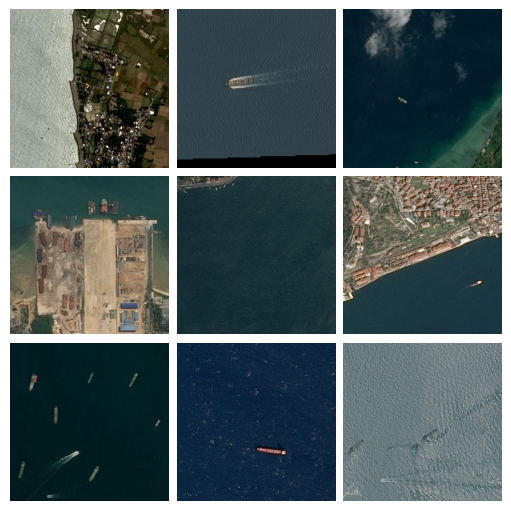

In [14]:
plot_train_image(masks[~masks['EncodedPixels'].isna()].sample(9),path_train)

### Image without a ship

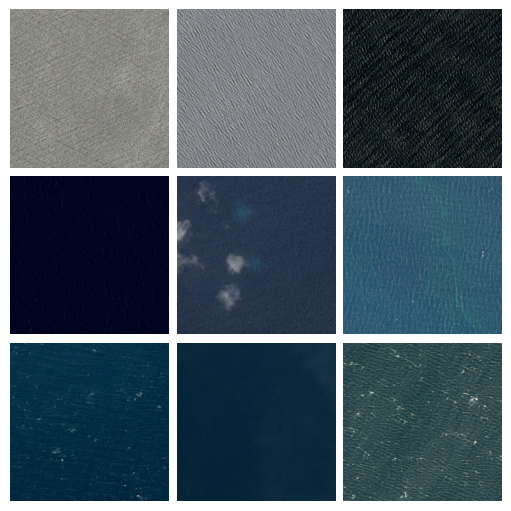

In [15]:
plot_train_image(masks[~masks['EncodedPixels'].notna()].sample(9),path_train)

### Mask for one of the images 

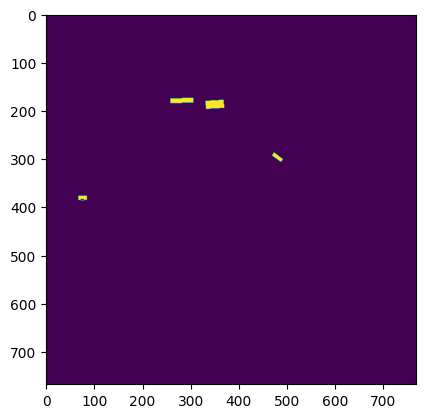

In [16]:
img0 = combine_images_masks(list(masks[masks['ImageId']=='000194a2d.jpg']['EncodedPixels']))
plt.imshow(img0);

#### There are images in our data that do not have ships, so we will separate them into separate groups with and without ships. And build a histogram 

In [17]:
data_wo_ship=masks[masks['EncodedPixels'].isna()]
data_ship=masks[masks['EncodedPixels'].notna()]

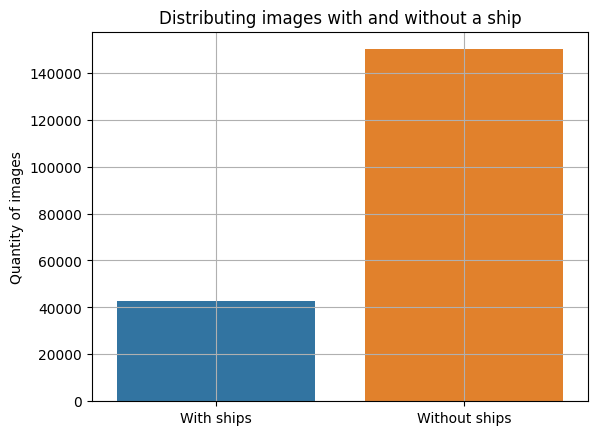

In [18]:
sns.barplot(x=['With ships','Without ships'], y=[data_ship['ImageId'].nunique(), data_wo_ship['ImageId'].nunique()])
plt.title("Distributing images with and without a ship")
plt.grid()
plt.ylabel('Quantity of images')
plt.show()

In [19]:
df_count_ship= data_ship.pivot_table(index='ImageId',aggfunc='count')

#### Let's build a histogram and see how many ships are in how many images 

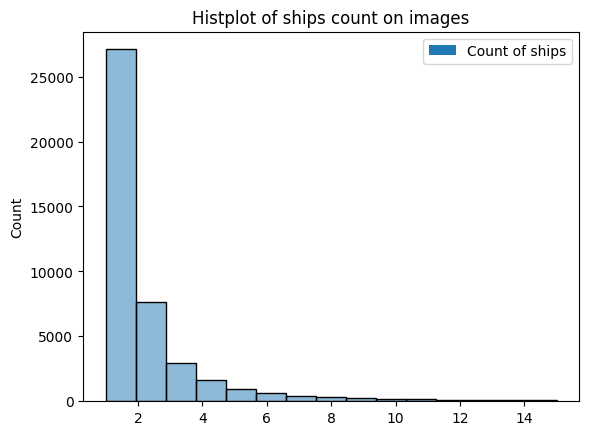

In [20]:
sns.histplot(df_count_ship,bins=15);
plt.legend(['Count of ships'])
plt.title("Histplot of ships count on images");

In [21]:
sample_size = df_count_ship['EncodedPixels'].value_counts()
sample_size


EncodedPixels
1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
14       76
13       75
15       66
Name: count, dtype: int64

#### Before training our model, we need to decide which strategy we will choose. We can balance our sample and choose to have as many images without ships as, for example, images with 1 ship, or we can choose to have only 1% of all images without ships. We can also test this because we have images where the ship photos are very small and there is only 1 ship in the photo. For example, let's take df_count_ship - in our dataframe that we use to train our segmentation model, and in this dataframe, only 100 images without ship were added, but if you look and set the threshold to 100, you can see that we have 4735 such images, and how small the size of the ship is that you can barely see it in the photo, so you can experiment with the number of photos without ship to choose the optimal number




In [22]:
q_image_wo_ship= int(sample_size.reset_index()['count'].max()*1.25)
image_wo_ship = data_wo_ship['ImageId'].values[:q_image_wo_ship]
image_w_ship = data_ship['ImageId'].values
list_name_train_img= np.append(image_wo_ship,image_w_ship)

In [23]:
data_train= masks[masks['ImageId'].isin(list_name_train_img)]
df_count_ship= data_train.pivot_table(index='ImageId',aggfunc='count').reset_index()

#### This is how the data distribution for training will look like if we decide to take 25% more photos without a ship than photos with 1 ship 

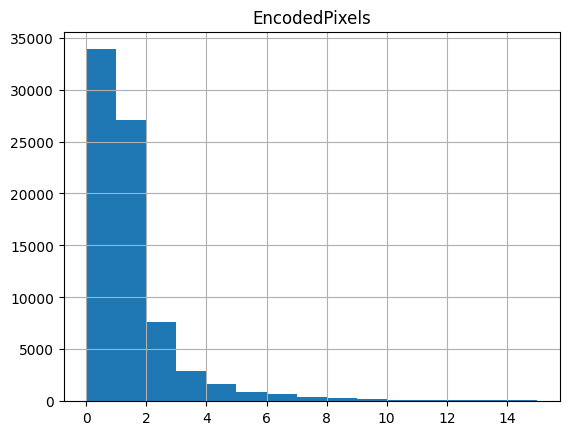

In [24]:
df_count_ship.hist(bins=15);

In [25]:
df_count_ship

,ImageId,EncodedPixels
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
76431,fff77c602.jpg,1
76432,fff909871.jpg,1
76433,fffcb6464.jpg,1
76434,fffd924fb.jpg,2


In [26]:
df_count_ship['EncodedPixels'].value_counts().reset_index()

,EncodedPixels,count
0,0,33880
1,1,27104
2,2,7674
3,3,2954
4,4,1622
5,5,925
6,6,657
7,7,406
8,8,318
9,9,243


In [27]:
dfcount_len_ship=data_ship.copy()
dfcount_len_ship['len']= data_ship['EncodedPixels'].apply(lambda x: count_len_ship(x) )
dfcount_len_ship=dfcount_len_ship.groupby('ImageId').agg('sum').reset_index().merge(df_count_ship.rename(columns={'EncodedPixels':'count'}),\
                                                                                    on='ImageId')

4735


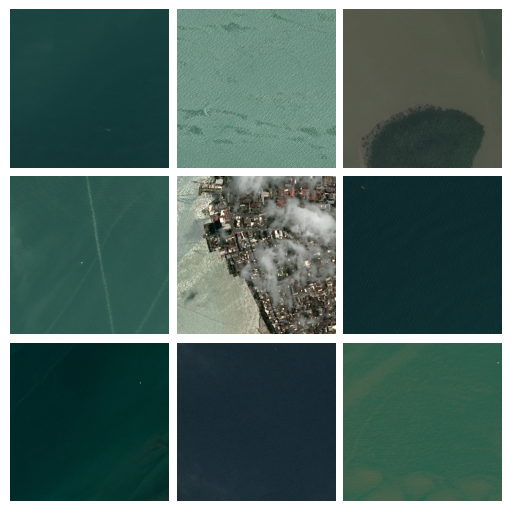

In [28]:
print(dfcount_len_ship[(dfcount_len_ship['count']==1)&(dfcount_len_ship['len']<100)]['ImageId'].nunique())
plot_train_image(dfcount_len_ship[(dfcount_len_ship['count']==1)&(dfcount_len_ship['len']<100)].sort_values(by='count',ascending=False).head(9),path_train)

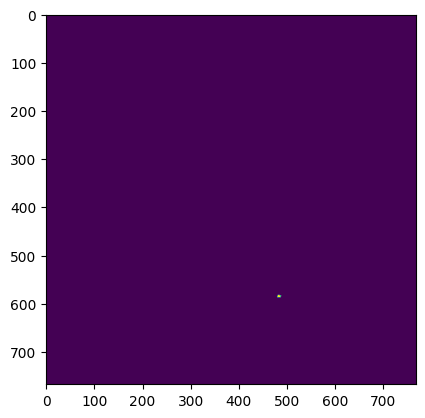

In [29]:
img0 = combine_images_masks(dfcount_len_ship[(dfcount_len_ship['count']==1)&(dfcount_len_ship['len']<100)].sort_values(by='count',ascending=False).head(1)['EncodedPixels'])
plt.imshow(img0);

#### This cell was created to allow you to adjust the limit on the entire number of ships in the photo, you can set a limit of no more than 1500 photos from each class 
if you comment out the lines 

In [30]:
filt_df= pd.DataFrame()
temp = df_count_ship[df_count_ship['EncodedPixels'].isin([0])]
f_temp = temp.sample(n=100, random_state=123) 
filt_df=pd.concat([filt_df,f_temp], axis=0)
other_df = df_count_ship[~df_count_ship['EncodedPixels'].isin([0])]
df_count_ship = pd.concat([filt_df, other_df], axis=0).reset_index(drop=True)


# filt_df= pd.DataFrame()
# filter_count_image=1500

# df_counts = df_count_ship['EncodedPixels'].value_counts().reset_index()
# df_counts.columns = ['EncodedPixels', 'count']  
# df_filtered = df_counts[df_counts['count'] > filter_count_image]

# for count in df_filtered['EncodedPixels'].unique():
#     if count !=0:
#         temp = df_count_ship[df_count_ship['EncodedPixels'].isin([count])]
#         f_temp = temp.sample(n=filter_count_image, random_state=123) 
#         filt_df=pd.concat([filt_df,f_temp], axis=0)
#     else:
#         temp = df_count_ship[df_count_ship['EncodedPixels'].isin([count])]
#         f_temp = temp.sample(n=100, random_state=123) 
#         filt_df=pd.concat([filt_df,f_temp], axis=0)


# other_df = df_count_ship[~df_count_ship['EncodedPixels'].isin(df_filtered['EncodedPixels'].unique())]

# df_count_ship = pd.concat([filt_df, other_df], axis=0).reset_index(drop=True)


#### In order to reduce the time and because we have more than 4 thousand images with very small ships, I decided to select only 100 images without ships and work with this data 

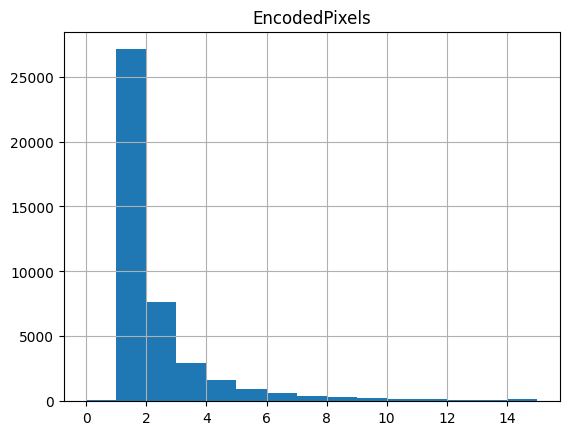

In [31]:
df_count_ship.hist(bins=15);

In [32]:
train_gen = make_image_gen(data_ship,path_train, batch_size=4)
train_x, train_y = next(train_gen)
print('x', train_x.shape,"\n",'y', train_y.shape)

x (4, 128, 128, 3) 
 y (4, 128, 128, 1)


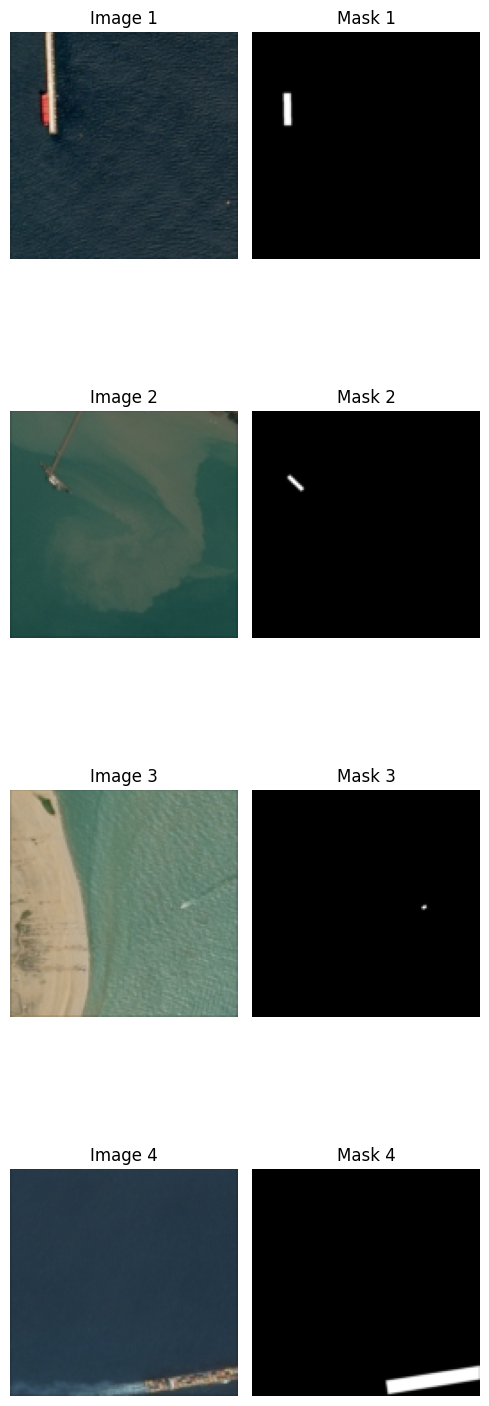

In [33]:
plot_images_masks(train_x, train_y)

### Create train and validation data

In [34]:
df_count_ship=df_count_ship.rename(columns={'EncodedPixels':'count'})
train_index, valid_index = train_test_split(df_count_ship, 
                 test_size = 0.1, 
                 stratify = df_count_ship['count'],
                random_state=123)

train_df = masks.merge(train_index,on='ImageId')
val_df = masks.merge(valid_index,on='ImageId')

# Training models  

### Training the segmentation model 

In [35]:
train_gen = make_image_gen(train_df, path_train,batch_size=BATCH_SIZE)
valid_gen = make_image_gen(val_df, path_train,batch_size=BATCH_SIZE)
cur_gen = custom_aug_gen(train_gen)


train_steps = len(train_df) // BATCH_SIZE
valid_steps = len(val_df) // BATCH_SIZE

model = UNet() 
model.compile(optimizer='adam', 
              loss= dice_loss , #'binary_crossentropy', 
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Train the model
history1= model.fit(train_gen, # cur_gen
          steps_per_epoch=train_steps, 
          epochs=EPOCHS,
          validation_data=valid_gen, 
          validation_steps=valid_steps,
          callbacks=[checkpoint, early_stop])


Epoch 1/2
  14/1150 [..............................] - ETA: 3:29:40 - loss: 0.9889 - accuracy: 0.1371

Exception ignored in: <function _xla_gc_callback at 0x79d0f51d17e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

### Checking the accuracy of the model 

In [36]:
image_batch, mask_batch = next(valid_gen) 
dice_score = model.evaluate(image_batch, mask_batch)
print(f"Dice Score: {np.mean(dice_score):.4f}")


2/2 [==============================] - 2s 736ms/step
Dice Score: 0.0120


#### Here are some examples, an image, a mask, and what our model returned

1/1 [==============================] - 0s 194ms/step


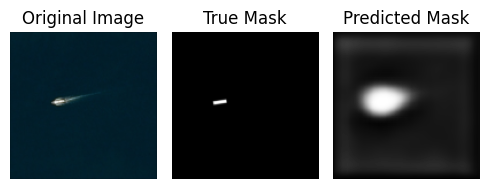

1/1 [==============================] - 0s 54ms/step


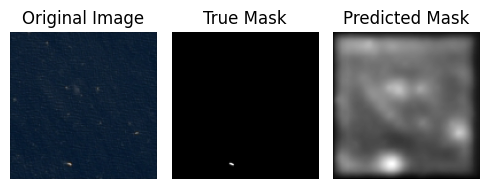

1/1 [==============================] - 0s 65ms/step


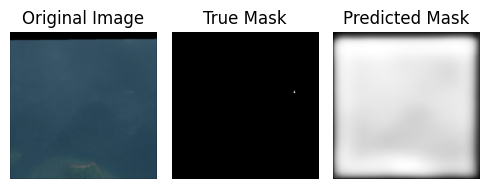

1/1 [==============================] - 0s 58ms/step


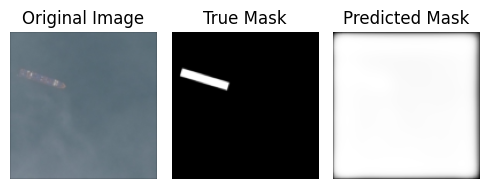

1/1 [==============================] - 0s 58ms/step


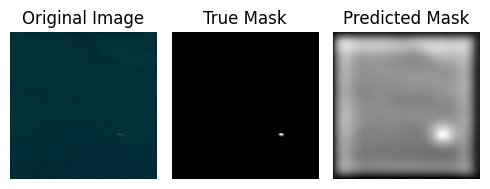

1/1 [==============================] - 0s 67ms/step


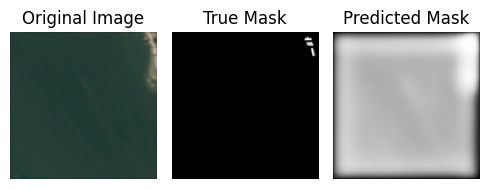

1/1 [==============================] - 0s 66ms/step


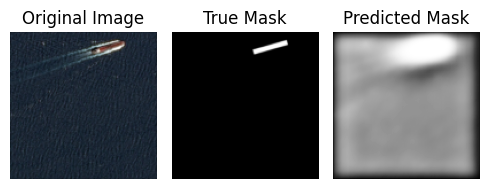

1/1 [==============================] - 0s 65ms/step


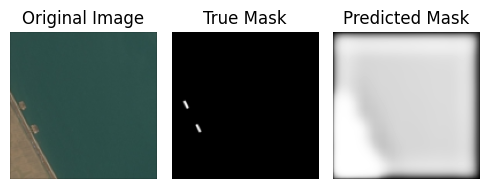

1/1 [==============================] - 0s 61ms/step


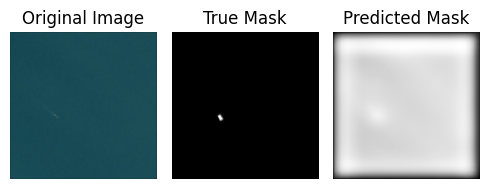

1/1 [==============================] - 0s 65ms/step


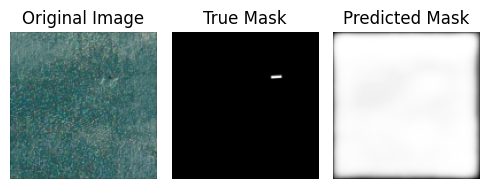

In [37]:
valid_gen = make_image_gen(val_df,path_train, batch_size=10)
image_batch, mask_batch = next(valid_gen) 

num_images = image_batch.shape[0]
for i in range(num_images):
    curr_image = image_batch[i].reshape(1, 128, 128, 3)  
    curr_mask = mask_batch[i]
    predicted_mask = model.predict(curr_image)
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))

    axs[0].imshow(curr_image[0])
    axs[0].set_title('Original Image')
    axs[1].imshow(curr_mask.squeeze(), cmap='gray') 
    axs[1].set_title('True Mask')

    axs[2].imshow(predicted_mask[0].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


#### Training of the model to classify the image whether there is a ship in the photo or not 

#### Preparing data for the classification model

Choose so that we have ships and the number was balanced and the model could detect both small and large ships, and it would also be necessary to clean the data because pictures of villages, cities are not appropriate, and there should be only photos of the sea 

In [38]:
list_for_classification = np.append(df_count_ship[~df_count_ship['count'].isin([0,1])]['ImageId'].values,\
                                   df_count_ship[df_count_ship['count'].isin([1])]['ImageId'].values[:1500],\
                                   )
list_for_classification = np.append(list_for_classification,data_wo_ship['ImageId'].values[:18000])

data_classification= masks[masks['ImageId'].isin(list_for_classification)]
data_classification = data_classification.groupby('ImageId').agg('count')
data_classification['has_ship'] = np.where(data_classification['EncodedPixels']==0,0,1)
data_classification=data_classification.reset_index().drop(columns='EncodedPixels')

In [39]:
train_index_for_class, valid_index_for_class = train_test_split(data_classification, 
                 test_size = 0.1, 
                 stratify = data_classification['has_ship'],
                random_state=123)

train_df_for_class = masks.merge(train_index_for_class,on='ImageId')
val_df_for_class = masks.merge(valid_index_for_class,on='ImageId')

In [40]:
train_gen_class = gen_image_for_classification(train_df_for_class, path_train ,batch_size=BATCH_SIZE)
valid_gen_class = gen_image_for_classification(val_df_for_class, path_train,batch_size=BATCH_SIZE)


In [45]:
train_steps = len(train_df_for_class) // BATCH_SIZE
valid_steps = len(val_df_for_class) // BATCH_SIZE

model_instance = ShipModelClassifications()
model_classification = model_instance.model
model_classification.compile(optimizer='adam', 
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history_classfication = model_classification.fit(train_gen_class, 
                     steps_per_epoch=train_steps, 
                     epochs=EPOCHS,
                     validation_data=valid_gen_class, 
                     validation_steps=valid_steps,
                     callbacks=[early_stop])

Epoch 1/2
  30/1043 [..............................] - ETA: 1:47:59 - loss: 0.8269 - accuracy: 0.5823

KeyboardInterrupt: 

### Checking the accuracy of the model 

In [46]:
im_val_x, im_val_y=next(valid_gen_class)
model_classification.evaluate(im_val_x,im_val_y)

2/2 [==============================] - 0s 148ms/step - loss: 0.5822 - accuracy: 0.6406


[0.5822134017944336, 0.640625]

1


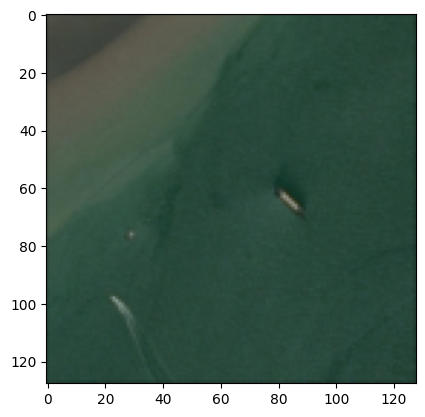

1


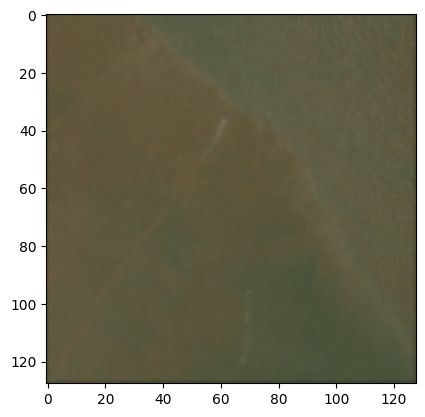

1


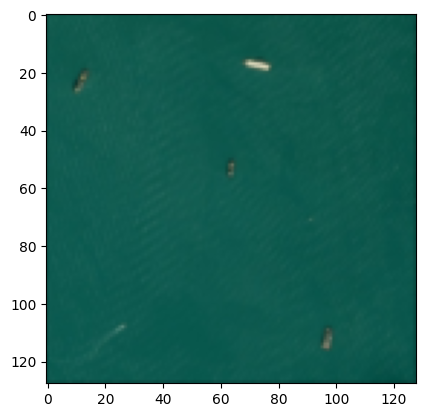

1


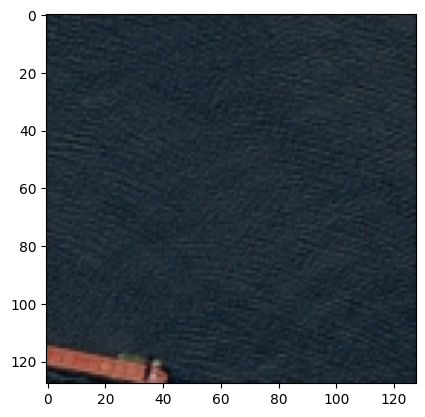

1


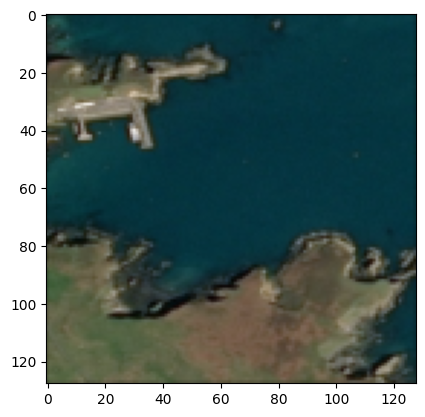

In [47]:
for i in range(im_val_x[:5].shape[0]):
    print(im_val_y[i])
    plt.imshow(im_val_x[i])
    plt.show()
    

In [48]:
class ClassificationUNetDetection:
    def __init__(self, classification_model, segmentation_model, threshold=0.5):
        self.classification_model = classification_model
        self.segmentation_model = segmentation_model
        self.threshold = threshold

    def dice(self,targets, inputs, smooth=1e-6):
        targets = tf.cast(targets, tf.float32)
        inputs = tf.cast(inputs, tf.float32)
        if len(targets.shape) == 3:
            targets = tf.expand_dims(targets, axis=-1)
        if len(inputs.shape) == 3:
            inputs = tf.expand_dims(inputs, axis=-1)

        axis = [1, 2, 3]
        intersection = K.sum(targets * inputs, axis=axis)
        dice_f = (2. * intersection + smooth) / (K.sum(targets, axis=axis) + K.sum(inputs, axis=axis) + smooth)
        return dice_f
    def predict_ship(self, image):
        input_image = np.expand_dims(image, axis=0)
        ship_prob = self.classification_model.predict(input_image)
        has_ship = ship_prob[0] >= self.threshold
        if has_ship:
            mask = self.segmentation_model.predict(input_image)
            return True, mask[0]
        else:
            return False, None
    
    def evaluate(self, dataset):
        dice_scores = []

        for img, true_mask in dataset:
            has_ship, predicted_mask = self.predict_ship(img)
            
            if has_ship:
                dice_score = self.dice(predicted_mask, true_mask).numpy()
                dice_scores.append(dice_score)

        mean_dice = np.mean(dice_scores)
        return mean_dice


In [49]:
mod = ClassificationUNetDetection(classification_model=model_classification, segmentation_model=model)

im_val_x, im_val_y = next(valid_gen)
dataset = list(zip(im_val_x, im_val_y))

mean_dice = mod.evaluate(dataset)
print(f"Mean Dice Coefficient: {mean_dice:.4f}")


1/1 [==============================] - 0s 47ms/step
Mean Dice Coefficient: 0.0026


In [50]:
mean_dice

0.0025808855